# CausalImpact

CausalImpact は BSTS（ベイズ構造時系列モデル）で予測した「架空の対照群」と「処置群（実測値）」とを比較することで平均処置効果を推定する手法。



## Bayesian Structural Time Series (BSTS)

Scott & Varian (2014) [Predicting the present with Bayesian structural time series.](https://www.inderscienceonline.com/doi/abs/10.1504/IJMMNO.2014.059942)

統計学者Steven Scottと経済学者Hal Varianが提案したnowcastingモデル（直近の予測や現時点の欠測値を予測することもできる）

### 構造時系列モデル（状態空間モデル）

- 観測方程式：$y_t = Z_t^{\mathrm{T}} \alpha_t+\varepsilon_t, \quad \varepsilon_t \sim \mathcal{N}\left(0, \sigma_t^2\right)$
- 状態方程式：$\alpha_{t+1} = T_t \alpha_t+R_t \eta_t, \quad \eta_t \sim \mathcal{N}\left(0, Q_t\right)$

### 状態の構成要素

#### 局所線形トレンド（local linear trend）

$$
\begin{aligned}
\mu_{t+1} & =\mu_t+\delta_t+\eta_{\mu, t}, & \eta_{\mu, t} \sim \mathcal{N}\left(0, \sigma_\mu^2\right) \\
\delta_{t+1} & =\delta_t+\eta_{\delta, t}, & \eta_{\delta, t} \sim \mathcal{N}\left(0, \sigma_\delta^2\right)
\end{aligned}
$$

- $\mu_t$：水準
- $\delta_t$：傾き

#### 季節成分（Seasonality）

$$
\gamma_{t+1}=-\sum_{s=0}^{S-2} \gamma_{t-s}+\eta_{\gamma, t}
$$

- $S$は季節数（例：$S=7$なら曜日効果）
- 総和がゼロになるように構成

#### 回帰成分（Regression Component）

静的または動的係数による回帰

$$
y_t=x_t^{\top} \beta_t+\varepsilon_t
$$

- 静的：$\beta_t = \beta$
- 動的：$\beta_{t+1} = \beta_t + \eta_{\beta,t}$


### spike and slab 事前分布

多次元の説明変数に対応するためモデルの変数選択

$$
p\left(\rho, \beta, 1 / \sigma_{\varepsilon}^2\right)=p(\rho) p\left(\sigma_{\varepsilon}^2 \mid \rho\right) p\left(\beta_\rho \mid \rho, \sigma_{\varepsilon}^2\right)
$$

ここで $\rho = (\rho_1, \dots, \rho_J)^\top$ は各変数が選ばれるかどうかのベクトル

- $\rho_j = 1$：変数$j$が選ばれる（$\beta_j \neq 0$）
- $\rho_j = 0$：除外される

$$
\begin{aligned}
p(\rho) & =\prod_j \pi_j^{\rho_j}\left(1-\pi_j\right)^{1-\rho_j} \\
\beta_\rho \mid \sigma_{\varepsilon}^2 & \sim \mathcal{N}\left(b_\rho, \sigma_{\varepsilon}^2\left(\Lambda_\rho^{-1}\right)^{-1}\right) \\
\frac{1}{\sigma_{\varepsilon}^2} & \sim \operatorname{Gamma}\left(\frac{\nu_{\varepsilon}}{2}, \frac{s_{\varepsilon}}{2}\right)
\end{aligned}
$$

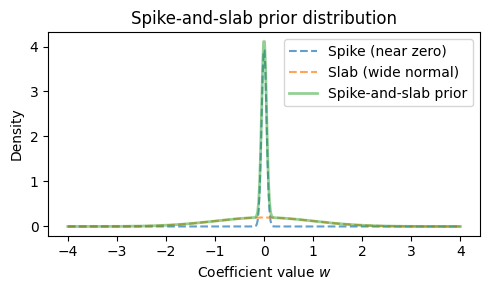

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Spike and slab prior parameters
p_inclusion = 0.5  # probability variable is "included" (slab)
slab_mean = 0.0
slab_std = 1.0

# range for weights (coefficients)
w = np.linspace(-4, 4, 400)

# spike: Dirac delta approximated by a narrow normal
spike = (1 - p_inclusion) * norm.pdf(w, 0, 0.05)
# slab: diffuse normal
slab = p_inclusion * norm.pdf(w, slab_mean, slab_std)

# combined spike-and-slab prior
spike_slab = spike + slab

plt.figure(figsize=(5, 3), dpi=100)
plt.plot(w, spike, "--", label="Spike (near zero)", alpha=0.7)
plt.plot(w, slab, "--", label="Slab (wide normal)", alpha=0.7)
plt.plot(w, spike_slab, label="Spike-and-slab prior", linewidth=2, alpha=0.5)
plt.xlabel("Coefficient value $w$")
plt.ylabel("Density")
plt.legend()
plt.title("Spike-and-slab prior distribution")
plt.tight_layout()
plt.show()

### パラメータの推論

MCMC（Gibbsサンプリング）で状態$\alpha$とパラメータ$\theta$を交互更新。

## Causal Impact

時系列データを元に平均処置効果を推定する方法。  
処置前の結果変数 $Y$ の時系列をベイズ構造時系列モデル（BSTS）で学習し、処置後の時点における反実仮想の対照群の値 $y_t^{(ct)}$ をBSTSで予測し、実測の処置後の値 $y_t^{(obs)}$ との差分から処置効果を推定する。


- 論文：[Inferring causal impact using Bayesian structural time-series models](https://research.google/pubs/inferring-causal-impact-using-bayesian-structural-time-series-models/)
- Rパッケージ：[CausalImpact](https://google.github.io/CausalImpact/CausalImpact.html)
- 一般向け記事：[効果測定に潜むバイアスを避けるには？ 広告を正しく評価するための 4 条件 - Think with Google](https://www.thinkwithgoogle.com/intl/ja-jp/marketing-strategies/data-and-measurement/measurementmatters2020/)

### 効果の推定

BSTSで反実仮想の事後予測分布から介入効果を予測する

時点ごとの効果（pointwise impact）：

$$
\phi_t^{(\tau)}=y_t-\tilde{y}_t^{(\tau)}
$$

累積効果：

$$
\sum_{t^{\prime}=n+1}^t \phi_{t^{\prime}}^{(\tau)} \quad \forall t=n+1, \ldots, m
$$

移動平均効果（running average effect）：

$$
\frac{1}{t-n} \sum_{t^{\prime}=n+1}^t \phi_{t^{\prime}}^{(\tau)} \quad \forall t=n+1, \ldots, m
$$

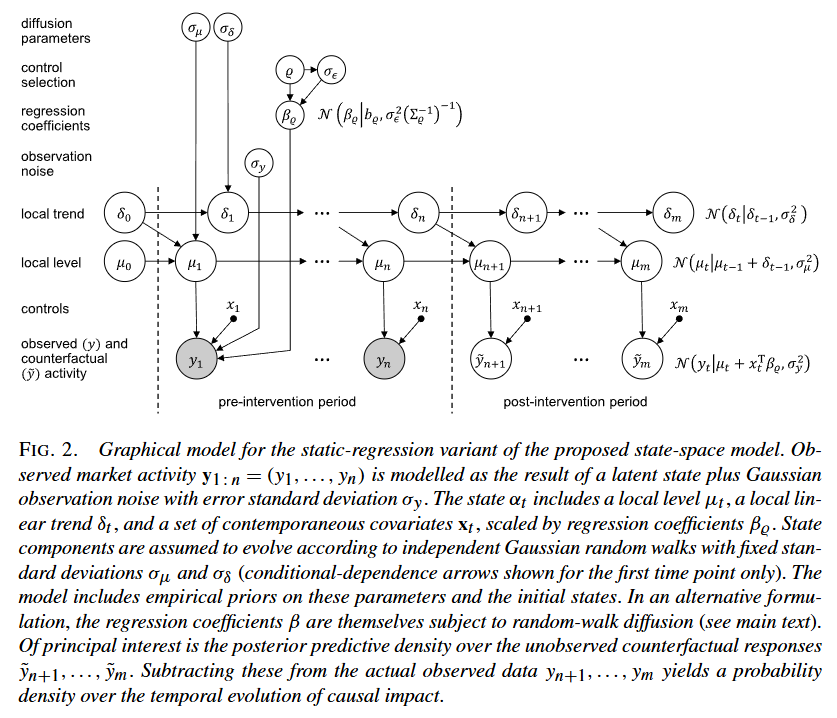

## どのくらいの精度で推定できるのか？

動的線形回帰で人工データを作り、どれくらい有意に検出できるかを実験した

$$
y_t=\beta_{t, 1} z_{t, 1}+\beta_{t, 2} z_{t, 2}+\mu_t+\varepsilon_t
$$


- $\beta_t$ はランダムウォーク：$\beta_{t+1} \sim N(\beta_t, 0.01^2)$
- $\mu_t$ はローカルレベル：$\mu_{t+1} \sim N(\mu_t, 0.1^2)$

評価結果

- 効果が1%未満の場合、検出力は低い。
- 効果が10%でも有意になる比率は30%ほど
- 効果が25%以上であれば80%以上で検出。
- 95%信頼区間の被覆率も理論値に近い。

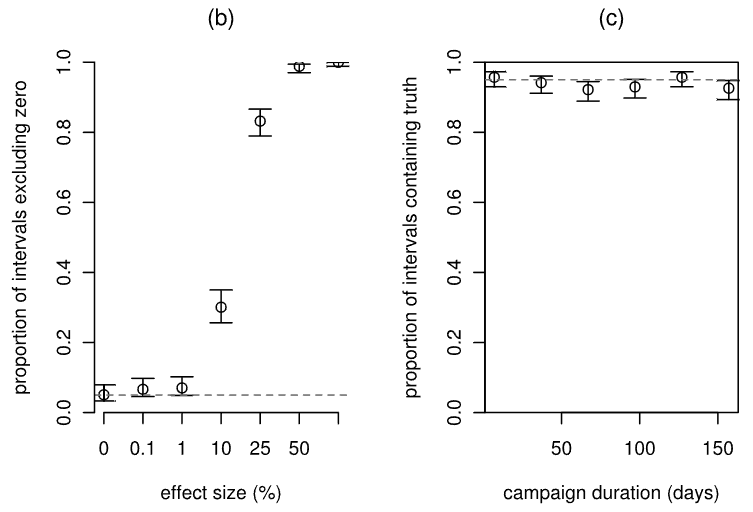

## 参考

- [Causal Impact -paper summary- - Speaker Deck](https://speakerdeck.com/hoxomaxwell/causal-impact-paper-summary)
- [CausalImpactは実装によって中身に重大な差異がある - 渋谷駅前で働くデータサイエンティストのブログ](https://tjo.hatenablog.com/entry/2023/12/04/170000)
